In [1]:
%load_ext autoreload
%autoreload 2

from math import sqrt
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.metrics import ConfusionMatrixDisplay

import torch
from torch import nn, Tensor
from torch.utils.data import random_split, DataLoader, TensorDataset, Dataset

from dataset import FourierSeries, collate_light_curves

# Dataset

A synthetic dataset with irregularly sampled time series. 

Dataset has two classes: sinewaves and a three-component fourier series. Observation times, periods and phases are random. Time series have zero mean and unit standard deviation.

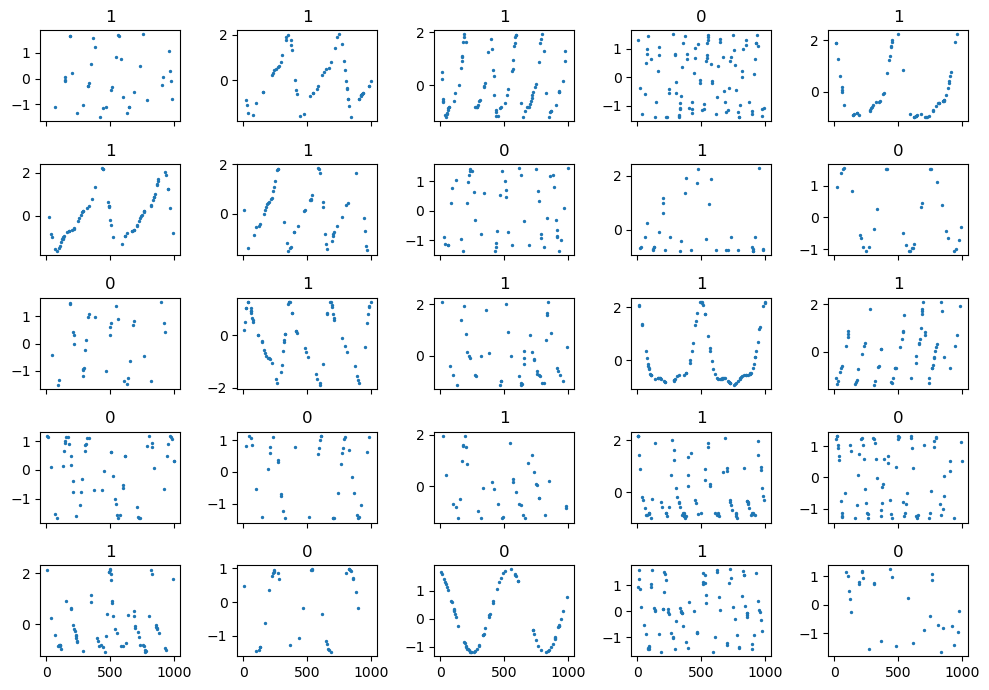

In [2]:
data_set = FourierSeries(samples_per_class=1000)

train_size = int(0.8*len(data_set)) # 80% to train
valid_size = len(data_set) - train_size
train_set, valid_set = random_split(data_set, [train_size, valid_size], generator=torch.Generator().manual_seed(1234))
train_loader = DataLoader(train_set, shuffle=True, batch_size=32, num_workers=0, collate_fn=collate_light_curves)
valid_loader = DataLoader(valid_set, batch_size=128, num_workers=0, collate_fn=collate_light_curves)

batch = next(iter(valid_loader))
data, mask = batch['light_curve']

fig, ax = plt.subplots(5, 5, figsize=(10, 7), tight_layout=True, sharex=True, sharey=False)
for k, ax_ in enumerate(ax.ravel()):
    ax_.scatter(data[k, 0, mask[k]], data[k, 1, mask[k]], s=2)
    ax_.set_title(f"{batch['label'][k]}")

# Transformer model for classification of irregularly sampled time series

First will use the STraTS architecture to classify the synthetic time series

Remarks of this architecture: 

- Replaces positional embedding with a Continuous Value Embedding module
- Uses an attention based model to fuse the sequence before classification (instead of averaging or using a classification token)

100%|███████████████████████████████████████████████████████████████| 50/50 [01:10<00:00,  1.41s/it]


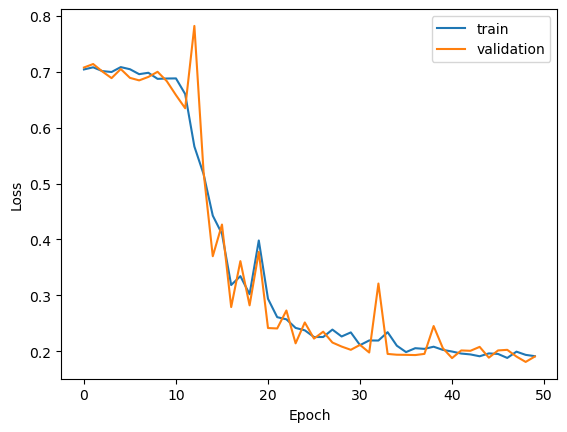

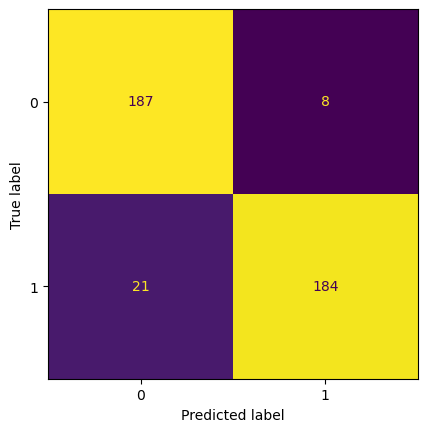

In [3]:
from models import STraTS
from trainer import train_and_evaluate

model = STraTS(embed_dim=48, num_heads=8, num_blocks=2, dropout_pbb=0.2)
train_and_evaluate(model, train_loader, valid_loader, epochs=50)

Now we test ATAT

Remarks of this architecture:

- Replaces the positional enconding with a time modulator based on Fourier series
- Appends a token at the beginning of the sequence, and then classifies using only that token

100%|███████████████████████████████████████████████████████████████| 50/50 [01:15<00:00,  1.51s/it]


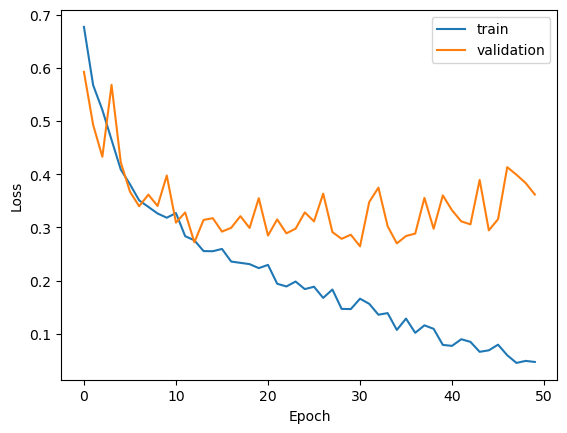

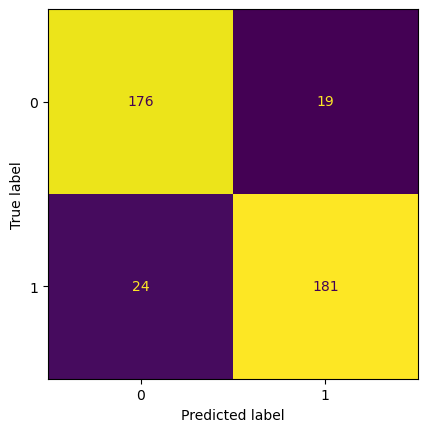

In [4]:
from models import ATAT

model = ATAT(T_max=1000, embed_dim=48, n_harmonics=16, num_heads=8, num_blocks=2, dropout_pbb=0.2)
train_and_evaluate(model, train_loader, valid_loader, epochs=50)